## Load Data and Clean
- load data
- calculate height from BMI & weight for sniff testing
- remove anomalous heights and ages
- note missing values in numerical features are being replaced with zeros
- drop rows with too much missing data
- impute remaining missing values (converted from 0 to nan) with median value
- numerical feature scaling


In [141]:

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

training_df = pd.read_csv("data/train.csv")
prediction_df = pd.read_csv("data/predict.csv")
TARGET_COLUMN = "zeta_disease"


#Data Processing
#get height
def height_from_bmi(row):
    if row["bmi"] <= 0 or row["weight"] <= 0:
        return np.nan
    height_in_inches = ((row["weight"] * 703.0) / row["bmi"]) ** 0.5
    return height_in_inches / 12  # Convert inches to feet


def clean_and_impute_zeros(df, columns_to_clean):
    # Replace 0 with NaN in target columns
    df[columns_to_clean] = df[columns_to_clean].replace(0, np.nan)

    # Drop rows with >1 NaN (across all columns)
    df = df.dropna(thresh=len(df.columns) - 1)  # Keep rows missing ≤1 value

    # Impute remaining NaNs with median
    imputer = SimpleImputer(strategy='median')
    df[columns_to_clean] = imputer.fit_transform(df[columns_to_clean])

    return df


training_df["height"] = training_df.apply(height_from_bmi, axis=1)
prediction_df["height"] = training_df.apply(height_from_bmi, axis=1)
view_height_df = training_df.copy()

#age limit: 95
#height limit: 4ft - 6.5ft
training_df = training_df[
    (training_df["age"].le(95)) &
    (training_df["height"].between(4.0, 6.5, inclusive='both')) &
    (training_df["height"].notna())
    ]

# Example usage:
columns_to_clean = [
    'weight',
    'bmi',
    'blood_pressure',
    'insulin_test',
    'cardio_stress_test',
    'liver_stress_test'
]

training_df = clean_and_impute_zeros(training_df, columns_to_clean)





/var/folders/m4/t_rq12813b3gjxfxfq7_t3c00000gn/T/ipykernel_32259/1471261550.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_clean] = imputer.fit_transform(df[columns_to_clean])


## Model Training

In [142]:

from sklearn.model_selection import train_test_split

X = training_df.drop(TARGET_COLUMN, axis=1)
y = training_df[TARGET_COLUMN]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

In [143]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
# scale numerical features
numeric_features = ["age", "weight", "bmi", "blood_pressure", "insulin_test", "liver_stress_test", "cardio_stress_test",
                    "years_smoking", "height"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create and train the classifier pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'bmi',
                                                   'blood_pressure',
                                                   'insulin_test',
                                                   'liver_stress_test',
                                                   'cardio_stress_test',
                                                   'years_smoking',
                                                   'height'])])),
                ('classifier', GradientBoostingClassifier())])

## Evaluation
- model performs ~80% f1-score on held-out set

In [153]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.85      0.79      0.81        14

    accuracy                           0.85        33
   macro avg       0.85      0.84      0.84        33
weighted avg       0.85      0.85      0.85        33



## Get Predictions

In [145]:
predictions = clf.predict(prediction_df)
prediction_df["zeta_disease"] = predictions
prediction_df

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease,height
0,24,151,39.5,69,72,1.3968,56,4,1,5.835024
1,27,179,35.5,89,156,1.6608,43,6,1,4.361257
2,34,147,26.9,76,74,1.6958,53,2,0,5.510834
3,35,206,32.4,73,127,1.4608,61,6,1,4.876034
4,60,193,29.8,62,192,1.7798,65,9,1,4.910027
5,45,120,36.5,108,50,1.2978,54,12,1,5.344943
6,20,139,38.2,61,77,1.5818,68,3,1,5.200372
7,23,137,31.2,70,73,1.4168,59,7,1,4.861218
8,36,195,30.5,59,141,1.4498,59,6,1,4.767210
9,19,193,25.8,84,66,1.7938,50,3,0,5.394803


# Data Analysis

## Feature Importance
- view feature importances in the model
- Weight was the most important feature for the model, followed by cardio stress test

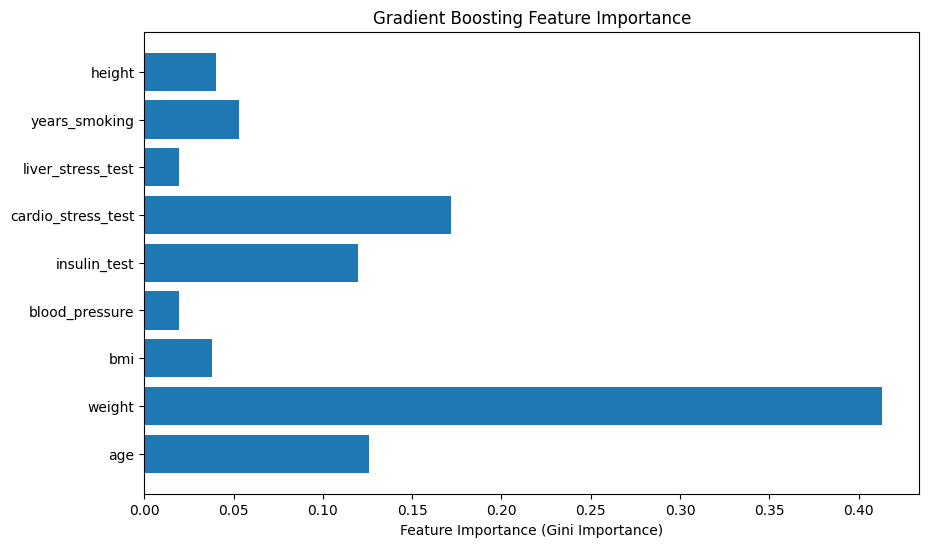

In [146]:

import matplotlib.pyplot as plt

# Plot feature importance
importances = clf.named_steps['classifier'].feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importances)
plt.xlabel("Feature Importance (Gini Importance)")
plt.title("Gradient Boosting Feature Importance")
plt.show()

## Height Anomalies
- the distribution of the heights seem off
- the average heights for the prediction set is lower than the average of the shortest nation population average on wikipedia
- a significant percentage of the heights in the training set under 4' or over 6'6"
- visualize distribution on histogram

In [147]:
anomalies = pd.DataFrame(
    #average height training/predicted
    {"average height (training set)": [view_height_df["height"].mean()],
     "average height (prediction set)": [prediction_df["height"].mean()],
     
     #average human height per wikipedia (no country dataset has an average less than 5'1")
     #https://en.wikipedia.org/wiki/Average_human_height_by_country#Second_table:_estimated_average_height_of_19-year-olds_in_2019
     "shortest world population mean height (east timor)": [5.13],
     
     #percentage training over 6.5 under 4
     "percent over 6.5 ft (training set)": [
         len(view_height_df.loc[view_height_df['height'] > 6.5]) / len(view_height_df) * 100],
     "percent under 4 ft (training set)": [
         len(view_height_df.loc[view_height_df['height'] < 4]) / len(view_height_df) * 100]

     })

anomalies.T

,0
average height (training set),5.155543
average height (prediction set),5.104705
shortest world population mean height (east timor),5.130000
percent over 6.5 ft (training set),2.204409
percent under 4 ft (training set),2.404810


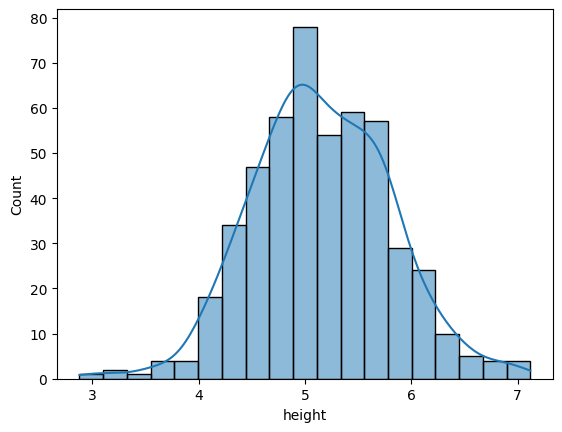

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram + KDE
sns.histplot(data=view_height_df, x='height', kde=True)
plt.show()



## Predicted Disease Distribution
- note that the proportion of positive disease values differ significantly between the training set vs the predictions
- could potentially be a sign of model overfitting

In [164]:
positive_rate_train = len(training_df["zeta_disease"].loc[training_df["zeta_disease"] == 1]) / len(training_df)
positive_rate_predict = len(prediction_df["zeta_disease"].loc[prediction_df["zeta_disease"] == 1]) / len(prediction_df)
positive_rates = pd.DataFrame({"positive rate (train)": [positive_rate_train], "positive rate (predict)": [positive_rate_predict]})
positive_rates.T

,0
positive rate (train),0.349544
positive rate (predict),0.850000
